# DDPG for Continous Action Environment

In this notebook, we will implement DDPG algorithm for Mountain car continous Environment.

## Mountain Car

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. We will experiment with the continouse version in this one.


![Mountain Car](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The observation is a ndarray with shape (2,) where the elements correspond to the position of the car along the x-axis and the velocity of the car.

The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1] and multiplied by a power of 0.0015.

A negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

You can read more the MountainCar Continous environment [here](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

## Continous Action Spaces

It's conceptually the same as for discrete action spaces. In discrete action spaces you have a discrete distribution like the categorical distribution and you calculate the log pi probabilities using its mass function. In continuous action spaces you use a continuous distribution like the Gaussian distribution and calculate the log pi “probabilities” using its density function. Everything else is the same.

So instead of having network that outputs the parameters for a categorical distribution, you have a network that outputs parameters for (usually) a Gaussian distribution (i.e. the mean and standard deviation)

But, usually we just output the mean using a neural network, and have a separate set of learnable parameters for std (in log space) for each action. For example, if we 3 continous actions then we will have a neural network which will output the means for these actions and then separate 3 parameters which will represent the log std of these actions. We still learn these log std but they are not dependent on state. We just have a log std for each action.

Other approaches for std include:
- Having a std as output of neural network just as the mean.
- Initializing some std for all actions at start and then steadily decrease if using a std_decay hyperparameter as the training progresses.


You can use any appraoch you like.



## Reward Function

As mentioned above, s negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

However, you can change this reward function and write a custom one if you like and think it will make the agent learn better.

## DDPG Algorithm


DDPG (Deep Deterministic Policy Gradient) is an algorithm designed for environments with continuous action spaces. It is inspired by the DPG (Deterministic Policy Gradient) algorithm, but extends it with the power of deep learning to handle high-dimensional state and action spaces effectively.

DDPG operates under the actor-critic framework. It uses two neural networks: an actor network, which proposes actions given the current state, and a critic network, which evaluates these actions by estimating the Q-value function. The key idea is to update the actor's policy by following the gradient of the critic's Q-value function, leading to improved action choices over time.

The core mechanisms of DDPG include:

1. Target Networks: To stabilize training, DDPG employs target networks for both the actor and critic. These networks are slowly updated versions of the original networks, which help mitigate the risk of divergence by providing more stable target values.

2. Experience Replay: DDPG uses a replay buffer to store past experiences (state, action, reward, next state tuples). During training, mini-batches of these experiences are sampled uniformly to break correlations between consecutive updates and improve data efficiency.

3. Soft Updates: Instead of directly copying weights from the main networks to the target networks, DDPG performs soft updates, where the target networks' weights are slowly blended with the main networks' weights. This process smooths out learning and helps stabilize training.

4. Exploration Noise: To encourage exploration in the action space, DDPG adds noise to the actions proposed by the actor during training. This noise is typically generated by an Ornstein-Uhlenbeck process, which produces temporally correlated values suitable for physical control tasks.

DDPG is particularly effective for continuous action domains, such as robotic control and autonomous driving, due to its ability to learn precise action values and its use of neural networks to approximate complex functions. However, it can be sensitive to hyperparameters and requires careful tuning to achieve optimal performance.

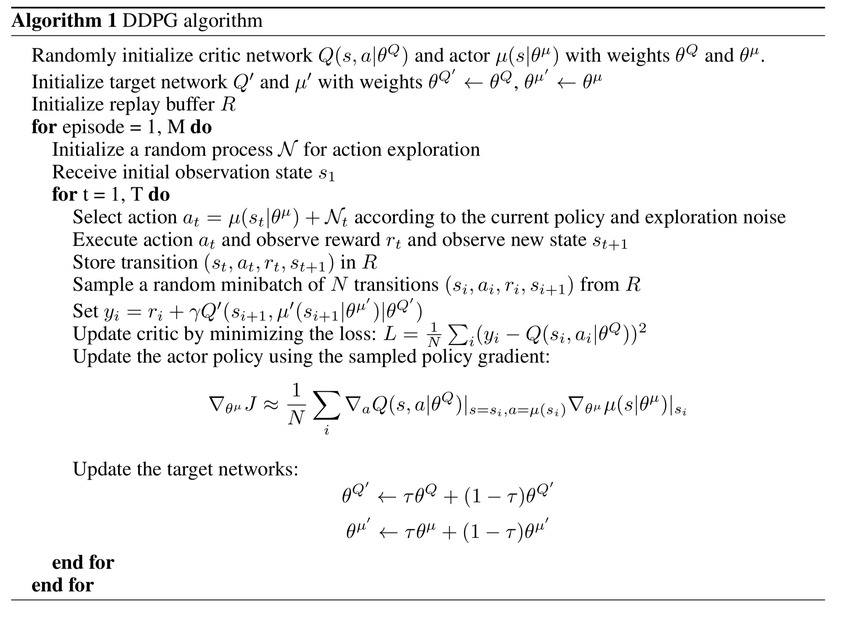

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create the environment
env = gym.make('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
state size: 2
action size: 1


### Implementing model




In [ ]:
Experience = collections.namedtuple(typename="Experience", field_names=['state', 'action', 'reward', 'done', 'nextState'])


class ExperienceBuffer(object):
    def __init__(self, args):
        self.buffer = collections.deque(maxlen=args['replay_size'])

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=True)
        states, actions, rewards, done, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), actions, np.array(rewards, dtype=np.float32), done, np.array(next_states)


class Actor(nn.Module):
    def __init__(self, input_dim, output_dim, action_scale):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, output_dim)
        self.action_scale = action_scale

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.action_scale * torch.tanh(self.fc3(x))
        return x


class Critic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, output_dim)

    def forward(self, state, action):
        x = F.relu(self.fc1(torch.cat([state, action], 1)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Agent(object):
    def __init__(self, env, exp_buffer, args):
        super(Agent, self).__init__()
        self.env = env
        self.exp_buffer = exp_buffer
        self.args = args
        self.actor = None
        self.critic = None
        self.target_actor = None
        self.target_critic = None
        self.build_model()
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.args['actor_lr'])
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.args['critic_lr'])

    def build_model(self):
        obs_dim = self.env.observation_space.shape[0]
        action_dim = self.env.action_space.shape[0]
        action_scale = self.env.action_space.high[0]

        self.actor = Actor(input_dim=obs_dim, output_dim=action_dim, action_scale=action_scale).to(device)
        self.target_actor = Actor(input_dim=obs_dim, output_dim=action_dim, action_scale=action_scale).to(device)
        self.target_actor.load_state_dict(self.actor.state_dict())

        self.critic = Critic(input_dim=obs_dim+action_dim, output_dim=1).to(device)
        self.target_critic = Critic(input_dim=obs_dim+action_dim, output_dim=1).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())

    def choose_action(self, state):
        x = torch.from_numpy(state).float().unsqueeze(0).to(device)
        return self.actor(x)

    def store_transition(self, state, action, r, done, state_next):
        exp = Experience(state, action, r, done, state_next)
        self.exp_buffer.append(exp)

    def learn(self):
        for _ in range(0, self.args['update_iteration']):

            buffer = self.exp_buffer.sample(self.args['batch_size'])
            states, actions, rewards, done, next_states = buffer

            states_tensor = torch.FloatTensor(states).to(device)
            actions_tensor = torch.FloatTensor(actions).to(device)
            rewards_tensor = torch.unsqueeze(torch.FloatTensor(rewards), 1).to(device)
            done_tensor = torch.unsqueeze(1-torch.FloatTensor(done), 1).to(device)
            next_states_tensor = torch.FloatTensor(next_states).to(device)

            # Compute the target Q value
            target_q = self.target_critic(next_states_tensor, self.target_actor(next_states_tensor))
            target_q = rewards_tensor + (done_tensor * self.args['gamma'] * target_q).detach()

            # Get current Q estimate
            current_q = self.critic(states_tensor, actions_tensor)

            # Compute critic loss
            critic_loss = F.mse_loss(current_q, target_q)
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss
            actor_loss = -self.critic(states_tensor, self.actor(states_tensor)).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.target_critic.parameters()):
                target_param.data.copy_(self.args['tau'] * param.data + (1 - self.args['tau']) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.target_actor.parameters()):
                target_param.data.copy_(self.args['tau'] * param.data + (1 - self.args['tau']) * target_param.data)

### Initializing the model and the environment

In [ ]:
args = {
    'replay_size': 5000,
    'batch_size': 128,
    'actor_lr': 1e-4,
    'critic_lr': 1e-3,
    'tau': 0.005,
    'exploration_noise': 0.1,
    'update_iteration': 200,
    'gamma': 0.99
}

In [ ]:
buffer = ExperienceBuffer(args=args)
agent = Agent(env, buffer, args)

### Training

In [ ]:
def custom_reward(state):
  _, velocity = state
  return abs(velocity)

In [ ]:
scores = []
avg_scores = []
for epoch in range(1000):
    state, done, truncated = env.reset(), False, False
    episode_r = []
    while (not done):
        action = agent.choose_action(state).cpu().detach().numpy().flatten()
        action = (action + np.random.normal(0, args['exploration_noise'], size=env.action_space.shape[0])).clip(
            env.action_space.low, env.action_space.high)
        state_next, r, done, info = env.step(action)
        r += custom_reward(state)
        agent.store_transition(state, action, r, done, state_next)

        state = state_next
        episode_r.append(r)

    agent.learn()
    scores.append(sum(episode_r))
    avg_scores.append(np.sum(episode_r) / len(episode_r))
    print("epoch: {} | avg_r: {} | ep_r: {} | len_ep {}".format(epoch, np.sum(episode_r) / len(episode_r),
                                                                sum(episode_r), len(episode_r)))
env.close()

epoch: 0 | avg_r: 0.00128180152459122 | ep_r: 1.2805197230666283 | len_ep 999
epoch: 1 | avg_r: -0.031620161796274124 | ep_r: -31.588541634477828 | len_ep 999
epoch: 2 | avg_r: 0.004488314192851124 | ep_r: 4.483825878658274 | len_ep 999
epoch: 3 | avg_r: 0.0033960559159744914 | ep_r: 3.3926598600585125 | len_ep 999
epoch: 4 | avg_r: 0.0036614363848326693 | ep_r: 3.6577749484478335 | len_ep 999
epoch: 5 | avg_r: 0.00013474546241485171 | ep_r: 0.13461071695243698 | len_ep 999
epoch: 6 | avg_r: 0.004556683804908852 | ep_r: 4.5521271211039425 | len_ep 999
epoch: 7 | avg_r: 0.00678020083976884 | ep_r: 6.773420638929074 | len_ep 999
epoch: 8 | avg_r: 0.00334067433254635 | ep_r: 3.337333658213802 | len_ep 999
epoch: 9 | avg_r: 0.003851436895025684 | ep_r: 3.8475854581306628 | len_ep 999
epoch: 10 | avg_r: 0.002511775686337175 | ep_r: 2.509263910650837 | len_ep 999
epoch: 11 | avg_r: 0.0012362334390937349 | ep_r: 1.2349972056546408 | len_ep 999
epoch: 12 | avg_r: 0.001990251338828691 | ep_r: 1

KeyboardInterrupt: 

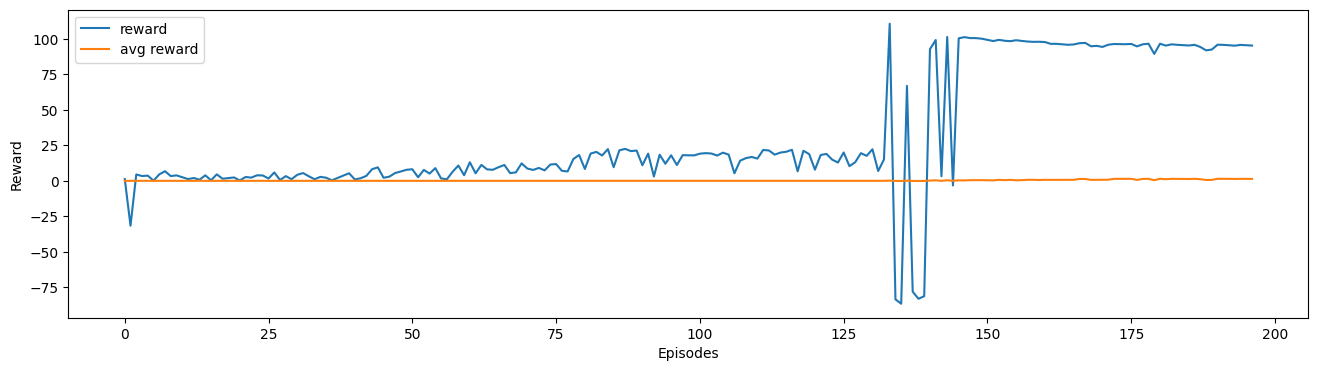

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores, label='reward')
plt.plot(avg_scores, label='avg reward')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)
max_steps = 999

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action = agent.choose_action(state).cpu().detach().numpy().flatten()

        next_state, r, done, info = env.step(action)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

show_video_of_model("MountainCarCont")
show_video("MountainCarCont")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initializati